In [1]:
%load_ext autoreload
%autoreload 2

import os
from dotenv import load_dotenv

# Load environment variables from .env file
load_dotenv("../../azimuth.env")

# Add PATH_ROOT to Python path
import sys
sys.path.append(os.getenv("PATH_ROOT"))

import numpy as np 
from matplotlib import pyplot as plt

print(f'PATH_ROOT: {os.getenv("PATH_ROOT")}')
# Set the style for publication-quality plots
plt.style.use('seaborn-v0_8-paper')  # Clean, professional style
plt.rcParams.update({
    'font.family': 'serif',  # Use serif fonts
    'font.serif': ['Arial'],  # Use Times New Roman
    'font.size': 10,         # Readable font size
    'axes.linewidth': 1.0,   # Thicker axes lines
    'axes.labelsize': 10,    # Size for axis labels
    'xtick.labelsize': 10,    # Size for x-tick labels
    'ytick.labelsize': 10,    # Size for y-tick labels
})



PATH_ROOT: /Users/thinhhoang/Documents/project-azimuth/


In [2]:
# Testing Thomas-Jensen Transit Process

import MARTINI.airspace.randomize_airspace as randomize_airspace
import MARTINI.arrivals.thomas as thomas
import MARTINI.airspace.geo as geo
import MARTINI.airspace.intersect as intersect
import numpy as np

# Generate a polygon
polygon, area = randomize_airspace.generate_unit_polygon(5, 500, seed=69420)

np.random.seed(69420)

entry_points, exit_points, velocity_vectors, parent_indices = thomas.generate_problem_thomas_jensen(polygon, lambda_parent=8e-3, mu=2, sigma=12,
                                                                                                    min_dist_to_vertex=42, min_transit_length=96,
                                                                                                    random_state=69420)
print(f'There are {len(entry_points)} entries generated')
print(f'There are {len(exit_points)} exits generated')
print(f'There are {len(velocity_vectors)} velocity vectors generated')


There are 36 entries generated
There are 36 exits generated
There are 36 velocity vectors generated


Looks like you are using a tranform that doesn't support FancyArrowPatch, using ax.annotate instead. The arrows might strike through texts. Increasing shrinkA in arrowprops might help.


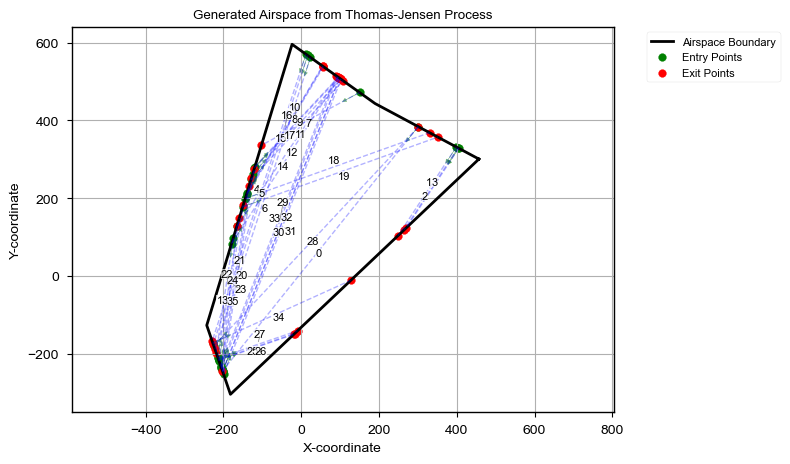

In [3]:
# Visualize the airspace
thomas.visualize_airspace(polygon, entry_points, exit_points, velocity_vectors)

In [4]:
# Create the segments object
segments = [(entry_points[i], exit_points[i]) for i in range(len(entry_points))]
print(f'There are {len(segments)} segments generated')

There are 36 segments generated


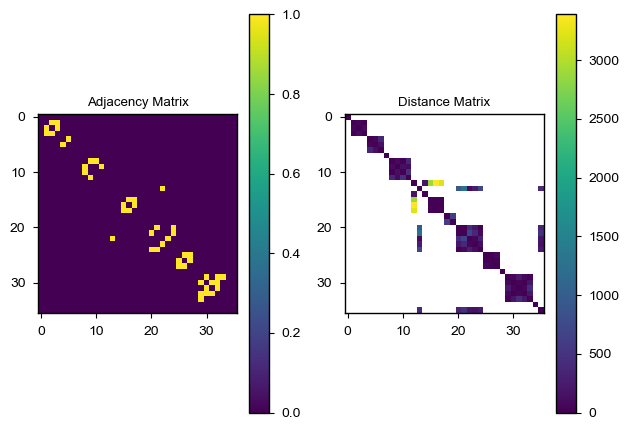

In [5]:
# Detect flows using Leiden Community Detection
from ALPHA.dirichlet.trajclus_features import compute_distance_matrix, get_adjacency_matrix_from_distance_matrix_by_thresholding
distance_matrix = compute_distance_matrix(segments, allow_cutoff=True,
                                          max_distance=2 * 40**2, max_dt=0.15)
adjacency_matrix = get_adjacency_matrix_from_distance_matrix_by_thresholding(distance_matrix,
                                                                             max_distance=100)

# Visualize the adjacency matrix
plt.figure()
plt.subplot(1,2,1)
plt.imshow(adjacency_matrix, cmap='viridis')
plt.colorbar()
plt.title('Adjacency Matrix')

plt.subplot(1,2,2)
plt.imshow(distance_matrix, cmap='viridis')
plt.colorbar()
plt.title('Distance Matrix')
plt.tight_layout()
plt.show()

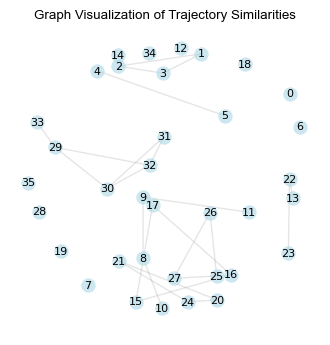

In [6]:
import networkx as nx

# Create a graph from the adjacency matrix
G = nx.from_numpy_array(adjacency_matrix)

# Set up the plot
plt.figure(figsize=(4, 4))

# Calculate node positions using a spring layout
# You can experiment with different layout algorithms like spring_layout, kamada_kawai_layout, circular_layout
pos = nx.spring_layout(G, k=1, iterations=50)

# Draw the network
# Nodes
nx.draw_networkx_nodes(G, pos, node_color='lightblue', 
                      node_size=100, alpha=0.6)

# Edges - only draw edges with weight above a threshold to reduce clutter
edge_weights = [G[u][v]['weight'] for u, v in G.edges()]
threshold = 0  # You can adjust this threshold
edges = [(u, v) for (u, v) in G.edges() if G[u][v]['weight'] > threshold]
nx.draw_networkx_edges(G, pos, edgelist=edges, 
                      alpha=0.2, edge_color='gray')

# Add labels
nx.draw_networkx_labels(G, pos, font_size=8)

plt.title('Graph Visualization of Trajectory Similarities')
plt.axis('off')
plt.show()

In [7]:
from IPython.display import Markdown, display
import pandas as pd

from ALPHA.dirichlet.leiden import leiden_community_detection
communities, quality = leiden_community_detection(adjacency_matrix,
                                                  resolution=1e-12,
                                                  n_iterations=1000)

display(Markdown(f"**Shape of communities:** {len(communities)}"))
display(Markdown(f"**Shape of adjacency matrix:** {adjacency_matrix.shape}"))
display(Markdown(f"**Found {len(np.unique(communities))} communities**"))
display(Markdown(f"**Partition quality:** {quality}"))

# Create a DataFrame with community sizes
community_sizes = pd.DataFrame({
    'Community': range(len(np.unique(communities))),
    'Number of Trajectories': [np.sum(np.array(communities) == i) for i in range(len(np.unique(communities)))]
})

# Display first 10 rows as a table
display(Markdown(f"## Community Sizes\n{community_sizes.head(20).to_markdown()}"))

most_frequent_communities = community_sizes[community_sizes['Number of Trajectories'] >= 2]['Community'].tolist()
display(Markdown(f'The most frequent communities are: {most_frequent_communities}'))

**Shape of communities:** 36

**Shape of adjacency matrix:** (36, 36)

**Found 18 communities**

**Partition quality:** 95.99999999998568

## Community Sizes
|    |   Community |   Number of Trajectories |
|---:|------------:|-------------------------:|
|  0 |           0 |                        5 |
|  1 |           1 |                        4 |
|  2 |           2 |                        3 |
|  3 |           3 |                        3 |
|  4 |           4 |                        3 |
|  5 |           5 |                        3 |
|  6 |           6 |                        3 |
|  7 |           7 |                        2 |
|  8 |           8 |                        1 |
|  9 |           9 |                        1 |
| 10 |          10 |                        1 |
| 11 |          11 |                        1 |
| 12 |          12 |                        1 |
| 13 |          13 |                        1 |
| 14 |          14 |                        1 |
| 15 |          15 |                        1 |
| 16 |          16 |                        1 |
| 17 |          17 |                        1 |

The most frequent communities are: [0, 1, 2, 3, 4, 5, 6, 7]

In [8]:
# # Print out community assignments for each trajectory
# community_assignments = pd.DataFrame({
#     'Trajectory Index': range(len(communities)),
#     'Community': communities
# })
# display(Markdown(f"## Community Assignments\n{community_assignments.to_markdown()}"))


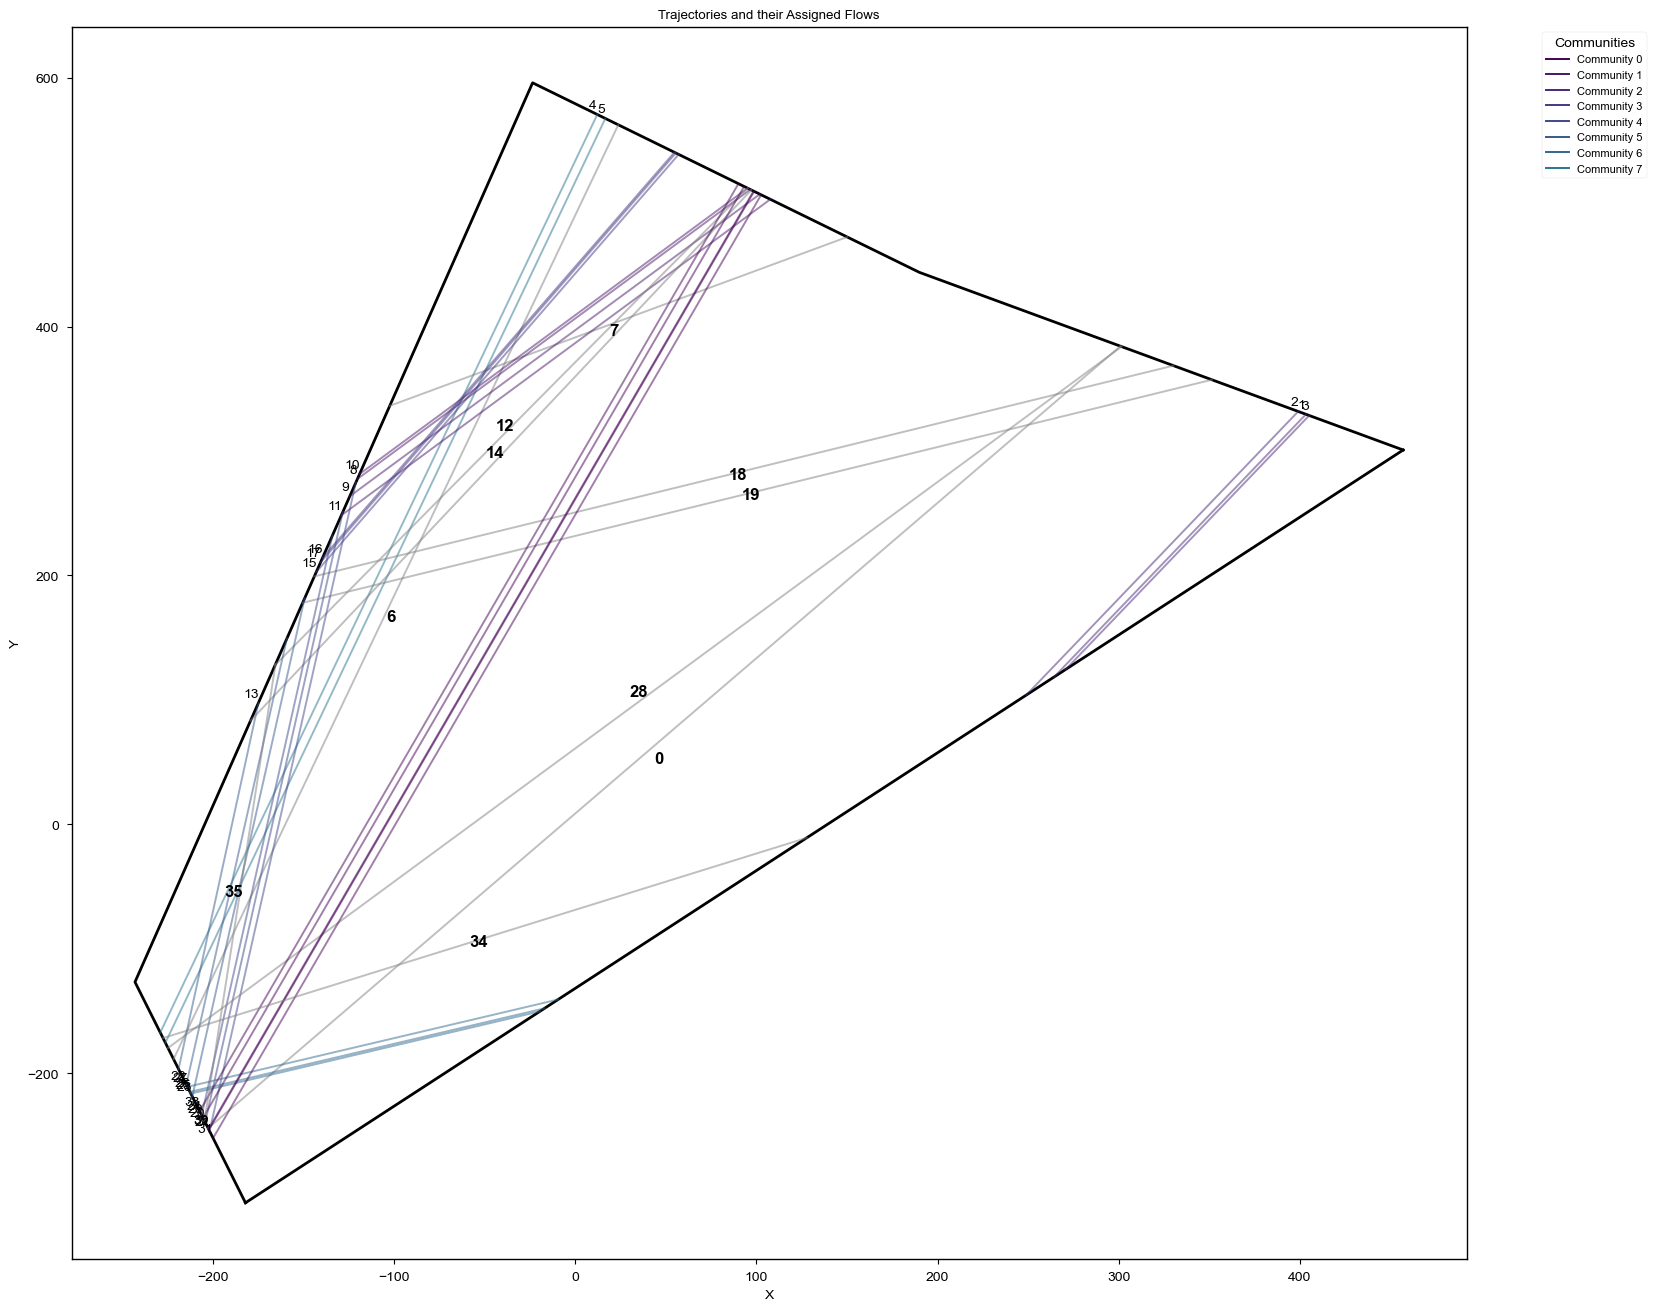

In [9]:
from adjustText import adjust_text

# Plot trajectories colored by community
plt.figure(figsize=(18, 16))

# Plot the airspace polygon
plt.plot(polygon[:,0], polygon[:,1], color='black', linewidth=2)
# Plot the remaining edge of the polygon
plt.plot([polygon[-1, 0], polygon[0, 0]], [polygon[-1, 1], polygon[0, 1]], color='black', linewidth=2)

mask = np.isin(communities, most_frequent_communities)


# Plot all trajectories, with colored trajectories for most frequent communities
for i in range(len(segments)):
    if mask[i]:
        # Colored plot for trajectories in most frequent communities
        plt.plot([entry_points[i][0], exit_points[i][0]], 
                [entry_points[i][1], exit_points[i][1]], 
                alpha=0.5,
                color=plt.cm.viridis(communities[i]/len(np.unique(communities))))
        # Add trajectory ID label at the entry point
        from adjustText import adjust_text
        
        texts1 = []
        texts1.append(plt.text(entry_points[i][0], entry_points[i][1], str(i), 
                 fontsize=10, color='black', 
                 verticalalignment='bottom', 
                 horizontalalignment='right'))
        adjust_text(texts1)
    else:
        # Gray plot for trajectories not in most frequent communities
        plt.plot([entry_points[i][0], exit_points[i][0]], 
                [entry_points[i][1], exit_points[i][1]], 
                alpha=0.5,
                color='gray')
        # Add trajectory ID label at the entry point
        # Calculate midpoint of the segment
        mid_x = (entry_points[i][0] + exit_points[i][0]) / 2
        mid_y = (entry_points[i][1] + exit_points[i][1]) / 2
        # Add small offset to avoid overlapping
        offset = 0.02 * (exit_points[i][1] - entry_points[i][1])  # 2% of segment height
        texts2 = []
        texts2.append(plt.text(mid_x, mid_y + offset, str(i),
                fontsize=12, color='black',
                verticalalignment='center',
                horizontalalignment='center', 
                weight='bold'))
        adjust_text(texts2)
        
# Create a custom legend for community colors
unique_communities = np.unique(np.array(communities)[mask])
legend_colors = [plt.cm.viridis(comm/len(np.unique(communities))) for comm in unique_communities]
legend_labels = [f'Community {comm}' for comm in unique_communities]

# Add legend
plt.legend(handles=[plt.Line2D([0], [0], color=color, label=label) 
                   for color, label in zip(legend_colors, legend_labels)],
          title='Communities',
          bbox_to_anchor=(1.05, 1), 
          loc='upper left')



plt.title('Trajectories and their Assigned Flows')
plt.xlabel('X')
plt.ylabel('Y')
plt.show()


# Inspection of trajectory distances

dv: 44.66165191798806, ds: 8.974484944058451, dt: 0.0
Distance between segment 23 and segment 22: 44.66165191798806


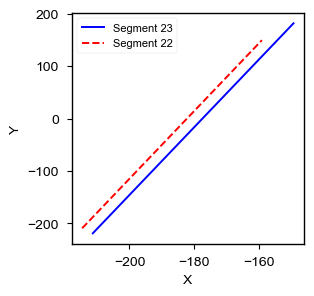

In [10]:
from ALPHA.dirichlet.trajclus_features import compute_segment_distance

segment_id_1 = 23
segment_id_2 = 22

dist = compute_segment_distance(segments[segment_id_1][0], segments[segment_id_1][1], segments[segment_id_2][0], segments[segment_id_2][1],
                         verbose=True, allow_cutoff=True, max_distance=2 * 360**2, max_dt=0.1)

print(f'Distance between segment {segment_id_1} and segment {segment_id_2}: {dist}')

plt.figure(figsize=(3,3))
# Plot the two segments being compared
plt.plot([segments[segment_id_1][0][0], segments[segment_id_1][1][0]], 
         [segments[segment_id_1][0][1], segments[segment_id_1][1][1]], 
         'b-', label=f'Segment {segment_id_1}')
plt.plot([segments[segment_id_2][0][0], segments[segment_id_2][1][0]], 
         [segments[segment_id_2][0][1], segments[segment_id_2][1][1]], 
         'r--', label=f'Segment {segment_id_2}')
plt.legend()
plt.xlabel('X')
plt.ylabel('Y')

plt.show()


In [11]:
adjacency_matrix[segment_id_1, segment_id_2]

1.0

# Merge Procedures

The merging procedures follow these logics:
- The merge points should locate far away from the hotspots.
- The merge points should be shared across aircraft to reduce confusions. We can use different merge points for different aircraft, but generally this is not quite desirable.
- The established flows should facilitate safe crossings in the airspace. 
